###Name : Deepanshu Sain
###Roll No. : 2023UCD2138

#Lab Assignment - 5
Performing fake news detection using the uploaded files "fake.csv" and "true.csv". The analysis includes the following :
1. Data Pre-processing- Stopword Removal, Stemming,Lemmatization
2. EDA- Word Cloud, Histogram
3. Feature Engineering - Bag of Words, N-gram, TF-IDF Vectorizer
4. Model Building- Logistic Regression, SVM, Decision Trees

In [31]:
import pandas as pd
import numpy as np
import re
import collections

# --- NLTK for Natural Language Processing Tasks ---
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

# --- Visualization Libraries ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# --- Scikit-learn for Feature Engineering and Machine Learning ---
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# --- Download necessary NLTK corpora ---
# This ensures that the required resources are available for the notebook to run.
required_nltk_data = [
    'stopwords',
    'punkt',
    'wordnet',
    'averaged_perceptron_tagger'
]

for resource in required_nltk_data:
    try:
        nltk.download(resource, quiet=True)
        print(f"Downloaded {resource}")
    except Exception as e:
        print(f"Error downloading {resource}: {e}")


Downloaded stopwords
Downloaded punkt
Downloaded wordnet
Downloaded averaged_perceptron_tagger


## Load and combine data

Load the `True.csv` and `Fake.csv` files into pandas DataFrames, add a label column to each to indicate whether the news is true or fake, and then combine them into a single DataFrame.


In [32]:
# Load the datasets from the provided CSV files
df_fake = pd.read_csv('/content/Fake.csv')
df_true = pd.read_csv('/content/True.csv')

# Add a 'class' column to each dataframe to serve as the target label
# 0 for Fake news, 1 for True news
df_fake['class'] = 0
df_true['class'] = 1

# Concatenate the two dataframes into a single dataframe
df = pd.concat([df_fake, df_true], ignore_index=True)

# Shuffle the dataframe to ensure random distribution of data
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


# --- Initial Data Inspection ---

# 1. Display the first 5 rows of the combined dataframe
print("First 5 rows of the combined dataset:")
print(df.head())
print("\n" + "="*50 + "\n")

# 2. Get a concise summary of the dataframe
print("DataFrame Info:")
df.info()
print("\n" + "="*50 + "\n")

# 3. Check the distribution of the 'class' column
print("Class Distribution (0: Fake, 1: True):")
print(df['class'].value_counts())

First 5 rows of the combined dataset:
                                               title  \
0  Ben Stein Calls Out 9th Circuit Court: Committ...   
1  Trump drops Steve Bannon from National Securit...   
2  Puerto Rico expects U.S. to lift Jones Act shi...   
3   OOPS: Trump Just Accidentally Confirmed He Le...   
4  Donald Trump heads for Scotland to reopen a go...   

                                                text       subject  \
0  21st Century Wire says Ben Stein, reputable pr...       US_News   
1  WASHINGTON (Reuters) - U.S. President Donald T...  politicsNews   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...  politicsNews   
3  On Monday, Donald Trump once again embarrassed...          News   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...  politicsNews   

                  date  class  
0    February 13, 2017      0  
1       April 5, 2017       1  
2  September 27, 2017       1  
3         May 22, 2017      0  
4       June 24, 2016       1  


DataFrame 

## Data preprocessing

Clean the text data by performing stopword removal, stemming, and lemmatization.


In [33]:
# Define a function for initial text cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation using regular expressions
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    return text

# Apply the cleaning function to the 'text' column
df['cleaned_text'] = df['text'].apply(clean_text)

print("Sample of cleaned text:")
print(df[['text', 'cleaned_text']].head())

Sample of cleaned text:
                                                text  \
0  21st Century Wire says Ben Stein, reputable pr...   
1  WASHINGTON (Reuters) - U.S. President Donald T...   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...   
3  On Monday, Donald Trump once again embarrassed...   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...   

                                        cleaned_text  
0  st century wire says ben stein reputable profe...  
1  washington reuters  us president donald trump ...  
2  reuters  puerto rico governor ricardo rossello...  
3  on monday donald trump once again embarrassed ...  
4  glasgow scotland reuters  most us presidential...  


In [34]:
# Apply tokenization to the cleaned text
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+') # Tokenize words consisting of alphanumeric characters
df['tokenized_text'] = df['cleaned_text'].apply(tokenizer.tokenize)

print("Sample of tokenized text:")
print(df[['cleaned_text', 'tokenized_text']].head())

Sample of tokenized text:
                                        cleaned_text  \
0  st century wire says ben stein reputable profe...   
1  washington reuters  us president donald trump ...   
2  reuters  puerto rico governor ricardo rossello...   
3  on monday donald trump once again embarrassed ...   
4  glasgow scotland reuters  most us presidential...   

                                      tokenized_text  
0  [st, century, wire, says, ben, stein, reputabl...  
1  [washington, reuters, us, president, donald, t...  
2  [reuters, puerto, rico, governor, ricardo, ros...  
3  [on, monday, donald, trump, once, again, embar...  
4  [glasgow, scotland, reuters, most, us, preside...  


In [35]:
# Get the set of English stopwords from NLTK
stop_words = set(stopwords.words('english'))

# Define a function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Apply the stopword removal function
df['stopwords_removed'] = df['tokenized_text'].apply(remove_stopwords)

print("Sample of text after stopword removal:")
print(df[['tokenized_text', 'stopwords_removed']].head())

Sample of text after stopword removal:
                                      tokenized_text  \
0  [st, century, wire, says, ben, stein, reputabl...   
1  [washington, reuters, us, president, donald, t...   
2  [reuters, puerto, rico, governor, ricardo, ros...   
3  [on, monday, donald, trump, once, again, embar...   
4  [glasgow, scotland, reuters, most, us, preside...   

                                   stopwords_removed  
0  [st, century, wire, says, ben, stein, reputabl...  
1  [washington, reuters, us, president, donald, t...  
2  [reuters, puerto, rico, governor, ricardo, ros...  
3  [monday, donald, trump, embarrassed, country, ...  
4  [glasgow, scotland, reuters, us, presidential,...  


In [36]:
# Initialize Stemmers
porter = PorterStemmer()
snowball = SnowballStemmer('english')

# Sample words from the dataset to demonstrate stemming
demonstration_words = ['political', 'politics', 'policy', 'policies', 'government', 'governing']

# Apply stemmers
porter_stems = [porter.stem(word) for word in demonstration_words]
snowball_stems = [snowball.stem(word) for word in demonstration_words]

print("Stemming Comparison on Dataset Words:")
print(f"{'Original':<15} {'Porter Stem':<15} {'Snowball Stem':<15}")
print("-" * 45)
for i in range(len(demonstration_words)):
    print(f"{demonstration_words[i]:<15} {porter_stems[i]:<15} {snowball_stems[i]:<15}")

Stemming Comparison on Dataset Words:
Original        Porter Stem     Snowball Stem  
---------------------------------------------
political       polit           polit          
politics        polit           polit          
policy          polici          polici         
policies        polici          polici         
government      govern          govern         
governing       govern          govern         


In [37]:
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

# Helper function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Function to perform lemmatization with POS tagging
def lemmatize_with_pos(tokens):
    pos_tagged_tokens = pos_tag(tokens)
    lemmatized_tokens = []
    for word, tag in pos_tagged_tokens:
        wn_tag = get_wordnet_pos(tag)
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos=wn_tag))
    return lemmatized_tokens

# Demonstrate lemmatization on the same sample words
lemmatized_sample = lemmatize_with_pos(demonstration_words)

print("\nLemmatization with POS tagging on Dataset Words:")
print(f"{'Original':<15} {'Lemmatized':<15}")
print("-" * 30)
for i in range(len(demonstration_words)):
    print(f"{demonstration_words[i]:<15} {lemmatized_sample[i]:<15}")


Lemmatization with POS tagging on Dataset Words:
Original        Lemmatized     
------------------------------
political       political      
politics        politics       
policy          policy         
policies        policy         
government      government     
governing       govern         


In [38]:
import nltk
try:
    nltk.download('averaged_perceptron_tagger_eng')
    print("Attempted to download 'averaged_perceptron_tagger_eng'.")
except Exception as e:
    print(f"Error downloading 'averaged_perceptron_tagger_eng': {e}")

Attempted to download 'averaged_perceptron_tagger_eng'.


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [39]:
# Apply the final lemmatization pipeline to the dataset
df['processed_text'] = df['stopwords_removed'].apply(lemmatize_with_pos)

# Join the tokens back into a single string for vectorization
df['final_text'] = df['processed_text'].apply(lambda tokens: ' '.join(tokens))

print("\nSample of final processed text:")
print(df[['text', 'final_text']].head())


Sample of final processed text:
                                                text  \
0  21st Century Wire says Ben Stein, reputable pr...   
1  WASHINGTON (Reuters) - U.S. President Donald T...   
2  (Reuters) - Puerto Rico Governor Ricardo Rosse...   
3  On Monday, Donald Trump once again embarrassed...   
4  GLASGOW, Scotland (Reuters) - Most U.S. presid...   

                                          final_text  
0  st century wire say ben stein reputable profes...  
1  washington reuters u president donald trump re...  
2  reuters puerto rico governor ricardo rossello ...  
3  monday donald trump embarrass country accident...  
4  glasgow scotland reuters u presidential candid...  


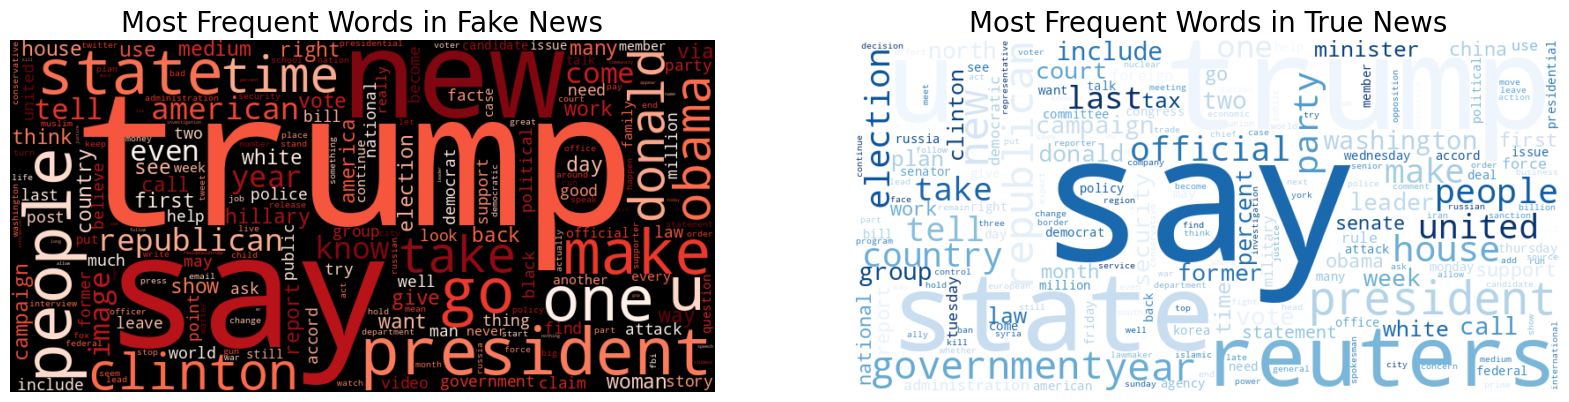

In [40]:
# Separate the text based on class
fake_news_text = ' '.join(df[df['class'] == 0]['final_text'])
true_news_text = ' '.join(df[df['class'] == 1]['final_text'])

# --- Generate Word Cloud for Fake News ---
wordcloud_fake = WordCloud(width=800, height=400, background_color='black', colormap='Reds', collocations=False).generate(fake_news_text)

# --- Generate Word Cloud for True News ---
wordcloud_true = WordCloud(width=800, height=400, background_color='white', colormap='Blues', collocations=False).generate(true_news_text)

# --- Plot the Word Clouds ---
plt.figure(figsize=(20, 10))

# Plot for Fake News
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.title('Most Frequent Words in Fake News', fontsize=20)
plt.axis('off')

# Plot for True News
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_true, interpolation='bilinear')
plt.title('Most Frequent Words in True News', fontsize=20)
plt.axis('off')

plt.show()

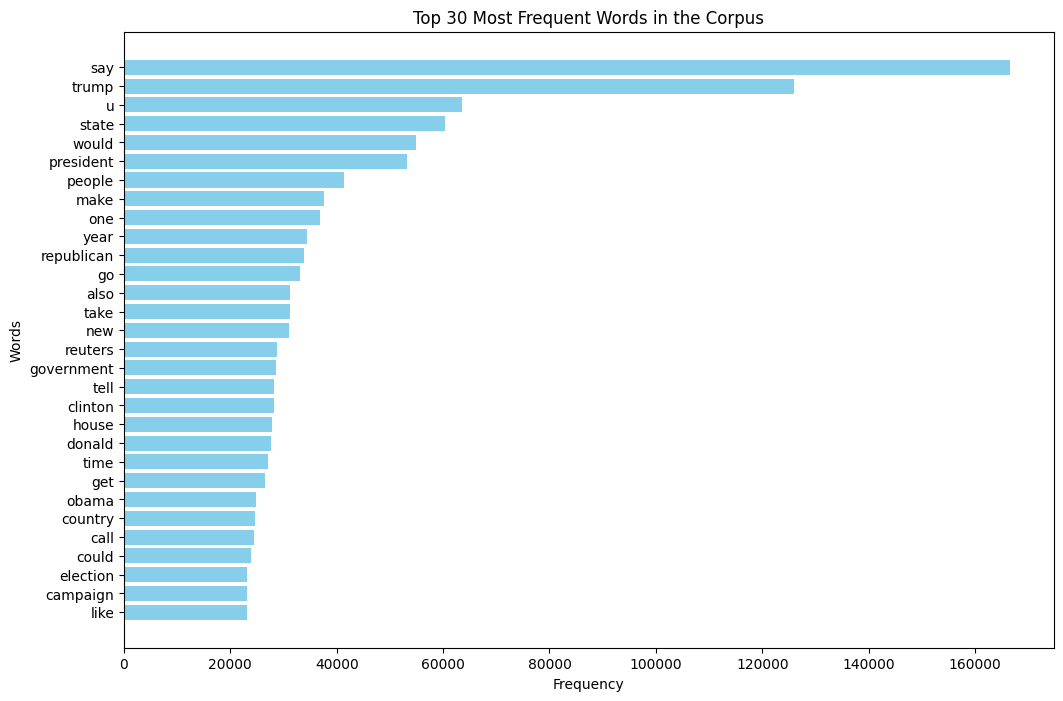

In [41]:
# Combine all processed text into one large list of words
all_words = [word for tokens in df['processed_text'] for word in tokens]

# Calculate word frequencies
freq_dist = nltk.FreqDist(all_words)

# Get the 30 most common words
most_common_words = freq_dist.most_common(30)

# Create a DataFrame for plotting
df_freq = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])

# --- Plot the Frequency Distribution ---
plt.figure(figsize=(12, 8))
plt.barh(df_freq['Word'], df_freq['Frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 30 Most Frequent Words in the Corpus')
plt.gca().invert_yaxis()  # Display the most frequent word at the top
plt.show()

## Feature Engineering

Convert the text data into numerical features using Bag of Words, N-gram, TF-IDF Vectorizer


In [42]:
# Initialize the CountVectorizer
bow_vectorizer = CountVectorizer(max_features=5000) # Limit to top 5000 features for efficiency

# Fit and transform the processed text data
X_bow = bow_vectorizer.fit_transform(df['final_text'])

# Print the shape of the resulting sparse matrix
print("Shape of the Bag-of-Words matrix:", X_bow.shape)

# Print a sample of the vocabulary
print("\nSample of vocabulary:", list(bow_vectorizer.vocabulary_.items())[:10])

Shape of the Bag-of-Words matrix: (44898, 5000)

Sample of vocabulary: [('st', np.int64(4248)), ('century', np.int64(712)), ('wire', np.int64(4924)), ('say', np.int64(3929)), ('ben', np.int64(458)), ('stein', np.int64(4286)), ('professor', np.int64(3491)), ('university', np.int64(4717)), ('also', np.int64(165)), ('hollywood', np.int64(2109))]


In [43]:
# Initialize CountVectorizer with unigrams and bigrams
ngram_vectorizer = CountVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit and transform the data
X_ngram = ngram_vectorizer.fit_transform(df['final_text'])

# Print the shape of the n-gram matrix
print("Shape of the N-gram matrix:", X_ngram.shape)

# Print a sample of n-gram features
print("\nSample of n-gram features:", [feature for feature in ngram_vectorizer.get_feature_names_out() if ' ' in feature][:10])

Shape of the N-gram matrix: (44898, 5000)

Sample of n-gram features: ['abc news', 'accord report', 'across country', 'act like', 'administration official', 'administration say', 'advocacy group', 'affordable care', 'african american', 'agency say']


In [44]:
# Initialize the TfidfVectorizer with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=10000) # Using a larger feature set

# Fit and transform the data to create the final feature matrix
X_final = tfidf_vectorizer.fit_transform(df['final_text'])
y_final = df['class']

# Print the shape of the final feature matrix
print("Shape of the final TF-IDF feature matrix:", X_final.shape)

Shape of the final TF-IDF feature matrix: (44898, 10000)


In [45]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2, random_state=42)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (35918, 10000)
Testing set shape: (8980, 10000)


###Model Building- Logistic Regression, SVM, Decision Trees

In [46]:
# --- Logistic Regression ---
# Initialize the model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model
lr_model.fit(X_train, y_train)

# Make predictions
lr_predictions = lr_model.predict(X_test)

# Evaluate the model
lr_accuracy = accuracy_score(y_test, lr_predictions)
lr_report = classification_report(y_test, lr_predictions, target_names=['Fake', 'True'])

print("--- Logistic Regression Performance ---")
print(f"Accuracy: {lr_accuracy:.4f}")
print("\nClassification Report:")
print(lr_report)

--- Logistic Regression Performance ---
Accuracy: 0.9873

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4710
        True       0.98      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [47]:
# --- Support Vector Machine (LinearSVC) ---
# Initialize the model
svm_model = LinearSVC(random_state=42)

# Train the model
svm_model.fit(X_train, y_train)

# Make predictions
svm_predictions = svm_model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_report = classification_report(y_test, svm_predictions, target_names=['Fake', 'True'])

print("--- Support Vector Machine (LinearSVC) Performance ---")
print(f"Accuracy: {svm_accuracy:.4f}")
print("\nClassification Report:")
print(svm_report)

--- Support Vector Machine (LinearSVC) Performance ---
Accuracy: 0.9949

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      0.99      1.00      4710
        True       0.99      1.00      0.99      4270

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [48]:
# --- Decision Tree ---
# Initialize the model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Make predictions
dt_predictions = dt_model.predict(X_test)

# Evaluate the model
dt_accuracy = accuracy_score(y_test, dt_predictions)
dt_report = classification_report(y_test, dt_predictions, target_names=['Fake', 'True'])

print("--- Decision Tree Performance ---")
print(f"Accuracy: {dt_accuracy:.4f}")
print("\nClassification Report:")
print(dt_report)

--- Decision Tree Performance ---
Accuracy: 0.9950

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      1.00      1.00      4710
        True       1.00      0.99      0.99      4270

    accuracy                           0.99      8980
   macro avg       1.00      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980

